#### Bayesian inference and Data assimilation SS2023

# Exercise 8 sample sample solution

#### Jin W. Kim (jin.won.kim@uni-potsdam.de)

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

## Problem 1

#### 1.1
It is straightforward that
$$
x_1 = (1 - \Delta t)x_0 + \sqrt{2\Delta t} \xi_0
$$
and
\begin{align*}
x_2 &= (1 - \Delta t)x_1 + \sqrt{2\Delta t} \xi_1 \\
&= (1 - \Delta t)((1 - \Delta t)x_0 + \sqrt{2\Delta t} \xi_0)+ \sqrt{2\Delta t} \xi_1 \\
&=(1 - \Delta t)^2 x_0 + (1 - \Delta t)\sqrt{2\Delta t} \xi_0 + \sqrt{2\Delta t} \xi_1
\end{align*}
Therefore, $x_1$ is Gaussian with mean $(1 - \Delta t)x_0$ and variance $2\Delta t$. $x_2$ is also a Gaussian with mean $(1 - \Delta t)^2 x_0$ and variance $2(1 - \Delta t)^2 \Delta t + 2\Delta t$.

#### 1.2

In [2]:
"Initialization"
N = 10000      #number of samples
dt = 0.01
x0 = 2.0

ind_05 = int(0.5/dt)
ind_1 = int(1.0/dt)
ind_10 = int(10/dt)

In [3]:
"Run the simulation"
X = x0*np.ones(N)
for t in range(ind_10):
    if t == 0:
        x_0 = np.copy(X)
    if t == ind_05:
        x_05 = np.copy(X)
    if t == ind_1:
        x_1 = np.copy(X)
    X = (1-dt)*X + np.sqrt(2*dt)*np.random.normal(size=N) 
    
x_10 = np.copy(X)

Mean of the samples at time t=10 is 0.0012 and the variance is 1.0170


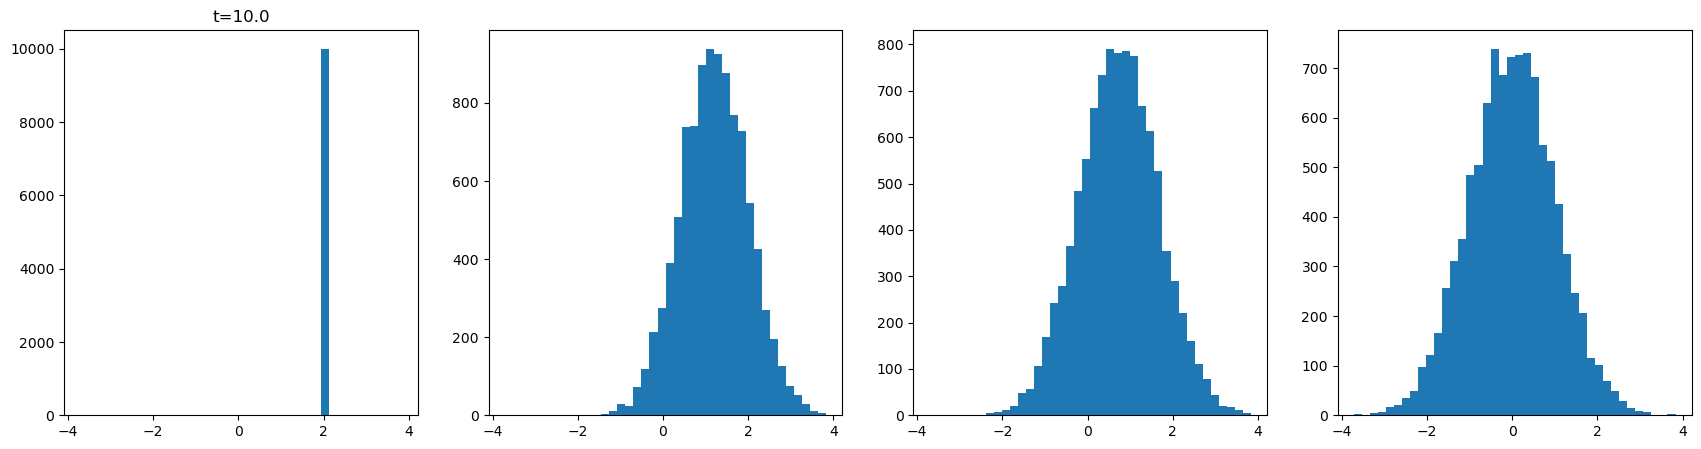

In [4]:
"Plot the result at time t = 0, 0.5, 1.0 and 10"
fig = plt.figure(figsize=(21,5))
ax1 = fig.add_subplot(141)
ax2 = fig.add_subplot(142)
ax3 = fig.add_subplot(143)
ax4 = fig.add_subplot(144)

x, b, p = ax4.hist(x_10, bins=40)        #Plot t=10 first to make bins equal.
_ = ax1.hist(x_0, bins=b)                #does not have to normalize y axis
_ = ax2.hist(x_05, bins=b)
_ = ax3.hist(x_1, bins=b)

ax1.set_title("t=0")
ax1.set_title("t=0.5")
ax1.set_title("t=1.0")
ax1.set_title("t=10.0")

print("Mean of the samples at time t=10 is {:6.4f} and the variance is {:6.4f}".format(x_10.mean(),x_10.var()))

#### 1.3
It converges to a Gaussian distribution with mean 0 and variance 1

#### 1.4 Digression: The time-reversal of the Ornstein-Uhlenbeck process
Consider the following Ornstein-Uhlenbeck process:
	$$
		{\rm d} X_t = - bX_t {\rm d} t + \sigma {\rm d} W_t,\quad X_0\sim \mu
	$$
	Let $\mu_t$ be the probability density of $X_t$. Under mild assumption, $\mu_t$ converges to $\mu_\infty:= N\big(0,\frac{\sigma^2}{2}bBig)$, namely, we can choose $T$ such that $\mu_T$ is arbitrarily close to the Gaussian distribution. 
	Meanwhile, we define the time reversal process as follows:
	$$
		{\rm d} Y_t = -b Y_t{\rm d} t + \nabla \log \mu_{T-t}(Y_t) + \sigma {\rm d} \tilde{W}_t,\quad Y_0 \sim \mu_T
	$$
	Then it is known that $Y_t \stackrel{d}{=}X_{T-t}$. Since $\mu_T$ is close to $\mu_\infty$ for a large enough $T$, the idea is to draw samples from $\mu_\infty$, then run the SDE for $Y_t$, and then the distribution of $Y_T$ will be similar to $\mu$. We call this method the "diffusion model". However, yet we don't know the "score function" $\nabla \log \mu_{T-t}(x)$. We approximate it by minimizing
	$$
	\min_\theta\;\int_0^T\|s(t,x;\theta)-\nabla \log \mu_t(x)\|^2{\rm d} t
	$$
	by using data samples from $\mu$ and simulate the forward SDE for $X$, where $s(\cdot;\theta)$ is some function approximation method, typically some variant of neural network.

## Problem 2

In [5]:
"functions"
def V(x):
    return ((x-4.)**2 - 2.)**2      #This works fine with vectorized numpy array as its input.

def DV(x):
    return 4*((x-4.)**2-2)*(x-4)

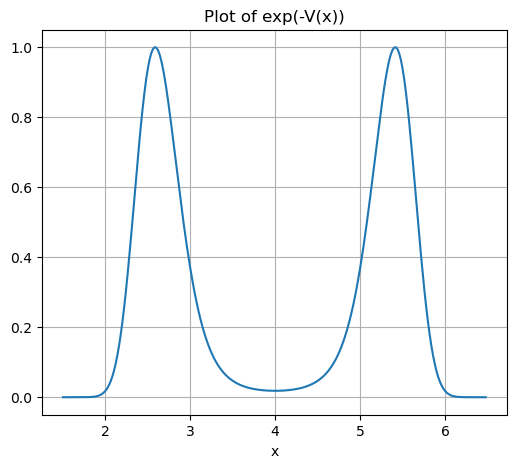

In [6]:
x = np.arange(1.5,6.5,0.02)
pi = np.exp(-V(x))

plt.figure(figsize=(6,5))
plt.plot(x,pi)
plt.title("Plot of exp(-V(x))")
plt.xlabel("x")
plt.grid()

In [7]:
"Initialization"
N = 10000      #number of samples
dt = 0.01
x0 = 1.0
T = 100

N_t = int(T/dt)

In [8]:
"Run the simulation"
X = x0*np.ones(N)
for t in range(N_t):
    X = X - DV(X)*dt + np.sqrt(2*dt)*np.random.normal(size=N) 

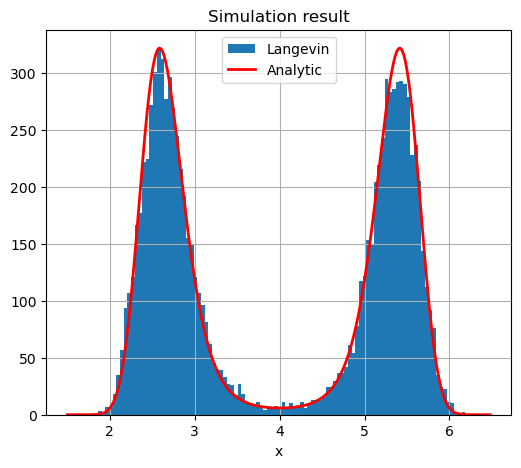

In [9]:
plt.figure(figsize=(6,5))
x_cnt,b,p = plt.hist(X,bins=100, label='Langevin')
plt.plot(x,x_cnt.max()*pi, color='red', linewidth=2.0, label='Analytic')
plt.title("Simulation result")
plt.xlabel("x")
plt.legend()
plt.grid()

In [10]:
print("The portion of samples with height larger than 6 is {:4.2f}%".format(100*(X>6).sum()/N))

The portion of samples with height larger than 6 is 0.20%


## Problem 3

#### 3.1
From the definition of supremum, for any $\epsilon > 0$, there exists a function $f$ such that $|f|_\infty \leq 1$ and
$$
\frac{1}{2}\big|\mathbb{E}_{\pi_1}[f] - \mathbb{E}_{\bar{\pi}_1}[f]\big| \geq d_{TV}(\pi_1,\bar{\pi}_1) - \epsilon
$$
We exploit that
$$
\begin{aligned}
\mathbb{E}_{\pi_1}[f] &= \int f(y) \pi_1(y){\rm d}y \\
&= \int f(y) \int P(x,y)\pi_0(x){\rm d}x{\rm d}y \\
&= \int \underbrace{\int f(y) P(x,y) {\rm d}y}_{\tilde{f}(x)}\; \pi_0(x){\rm d}x \\
&= \mathbb{E}_{\pi_0}[\tilde{f}]
\end{aligned}
$$
Since $P$ is a probability transition kernel, $|\tilde{f}|_\infty \leq 1$, and therefore we conclude that
$$
\begin{aligned}
d_{TV}(\pi_0,\bar{\pi}_0) &\geq \frac{1}{2}\big|\mathbb{E}_{\pi_0}[\tilde{f}] - \mathbb{E}_{\bar{\pi}_1}[\tilde{f}]\big| \\
&= \frac{1}{2}\big|\mathbb{E}_{\pi_1}[f] - \mathbb{E}_{\bar{\pi}_1}[f]\big| \\
& \geq d_{TV}(\pi_1,\bar{\pi}_1) - \epsilon
\end{aligned}
$$
The claim follows by taking arbitrarily small $\epsilon$.

#### 3.2
It is a direct consequence of the above result using mathematical induction.